### Bike_Sharing_Demand - Forecast use of a city bikeshare system

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
df_train = pd.read_csv('共享单车 train.csv')
df_test = pd.read_csv('共享单车 test.csv')

In [3]:
df_train.info()
df_test.info()
df_train.describe()
data = pd.concat([df_train,df_test],axis=0,ignore_index=True)#合并训练和测试

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 n

In [13]:
# Null 값은 없다.
  #   Column      Non-Null Count  Dtype  
 #---  ------      --------------  -----  
# 0   datetime    10886 non-null  object 
#datetime을 object > datetime으로 바꾸어 준다.

In [4]:
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [6]:
data.datetime = pd.to_datetime(data.datetime,format='%Y-%m-%d %H:%M:%S',errors='coerce')
def getyear(date_time):
    return date_time.year
def getmonth(date_time):
    return date_time.month          # 提取年份，月份，天和小时信息
def getday(date_time):
    return date_time.day
def gethour(date_time):
    return date_time.hour
data['year'] = data.datetime.apply(getyear)
data['month'] = data.datetime.apply(getmonth)
data['day'] = data.datetime.apply(getday)
data['hour'] = data.datetime.apply(gethour)

In [12]:
data.datetime

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
17374   2012-12-31 19:00:00
17375   2012-12-31 20:00:00
17376   2012-12-31 21:00:00
17377   2012-12-31 22:00:00
17378   2012-12-31 23:00:00
Name: datetime, Length: 17379, dtype: datetime64[ns]

In [15]:
data['temp_cat']

0        (8.9, 12.9]
1        (8.9, 12.9]
2        (8.9, 12.9]
3        (8.9, 12.9]
4        (8.9, 12.9]
            ...     
17374    (8.9, 12.9]
17375    (8.9, 12.9]
17376    (8.9, 12.9]
17377    (8.9, 12.9]
17378    (8.9, 12.9]
Name: temp_cat, Length: 17379, dtype: category
Categories (10, interval[float64]): [(0.8, 4.8] < (4.8, 8.9] < (8.9, 12.9] < (12.9, 16.9] ... (24.9, 28.9] < (28.9, 33.0] < (33.0, 37.0] < (37.0, 41.0]]

In [14]:
# 连续变量分箱
data['temp_cat'] = pd.cut(x=data.temp,bins=10,precision=1)
data['atemp_cat'] = pd.cut(x=data.atemp,bins=10,precision=1)
data['humi_cat'] = pd.cut(x=data.humidity,bins=10,precision=1)
data['windspeed_cat'] = pd.cut(x=data.windspeed,bins=10,precision=1)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
# 区分离散变量和连续变量
disvar = ['year','weather','holiday','season','workingday']
multi_disvar = ['hour','day','month']
convar_bin = ['atemp_cat','temp_cat','windspeed_cat','humi_cat']
convar = ['humidity','windspeed','temp']

In [17]:
# 绘制离散变量/连续变量与count柱状图
def plot_count(df,varlist,plot_type,col=2):
    nvar = len(varlist)
    row = int(np.ceil(nvar/col))
    fig = plt.figure(figsize=(12,10))
    for i in range(nvar):
        axe_name = 'ax'+str(i)
        axe_name = fig.add_subplot(row,col,i+1)
        if plot_type == 'bar':
            sns.barplot(x=varlist[i],y='count',data=df,ax=axe_name,color='purple')
        elif plot_type == 'point':
            sns.pointplot(x=varlist[i],y='count',data=df,ax=axe_name,ci=None,color='purple')
        elif plot_type == 'box':
            sns.boxplot(x=varlist[i],y='count',data=df,ax=axe_name,color='purple')
        elif plot_type == 'scatter':
            plt.scatter(x=df[varlist[i]],y=df['count'],color='purple')
            plt.xlabel(varlist[i])
            plt.ylabel('count')
    plt.subplots_adjust(hspace=0.7,wspace=0.5)

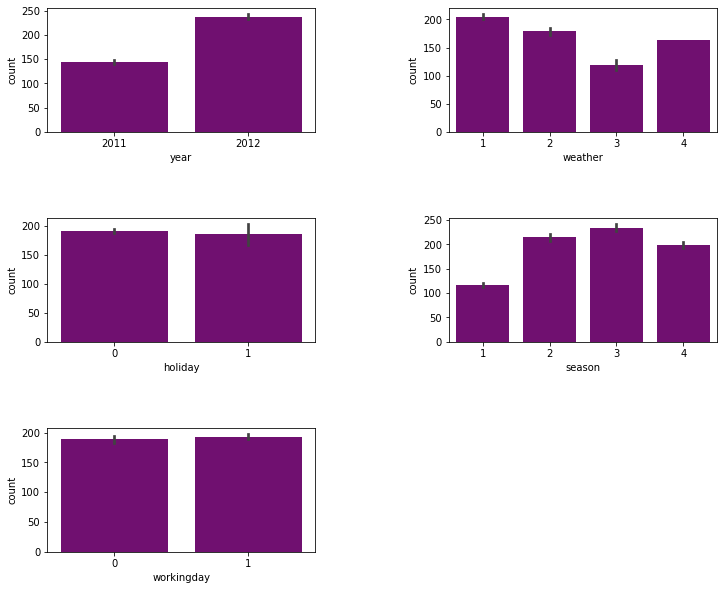

In [18]:
plot_count(data,disvar,'bar') # 绘制离散变量柱状图

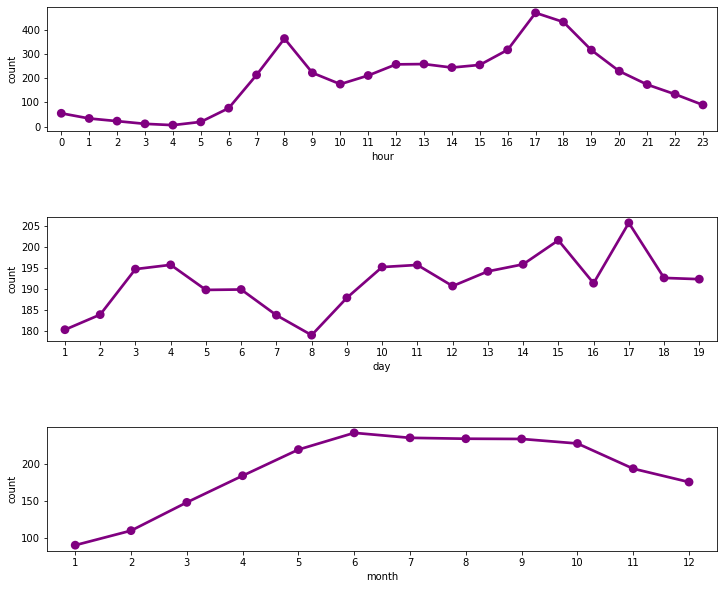

In [19]:
plot_count(data[data['count'].notnull()],multi_disvar,'point',col=1) # 绘制多值离散变量点线图

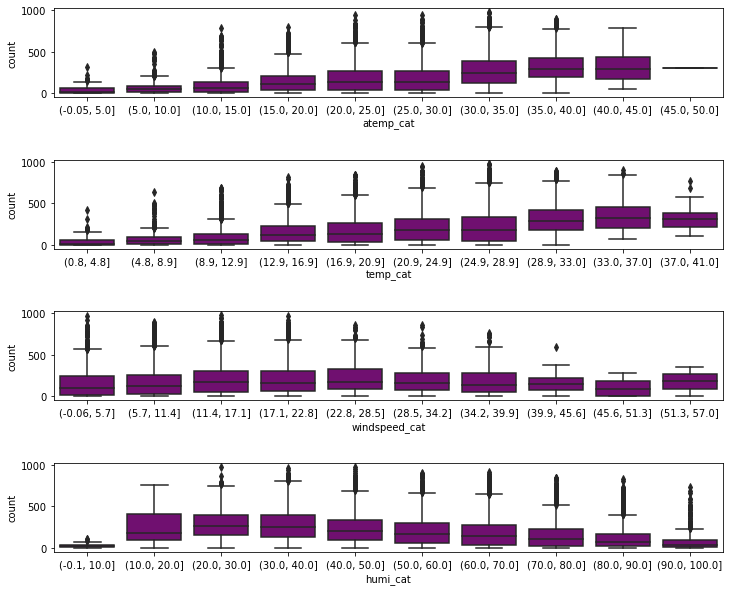

In [20]:
plot_count(data,convar_bin,'box',col=1) #绘制分箱连续变量箱线图

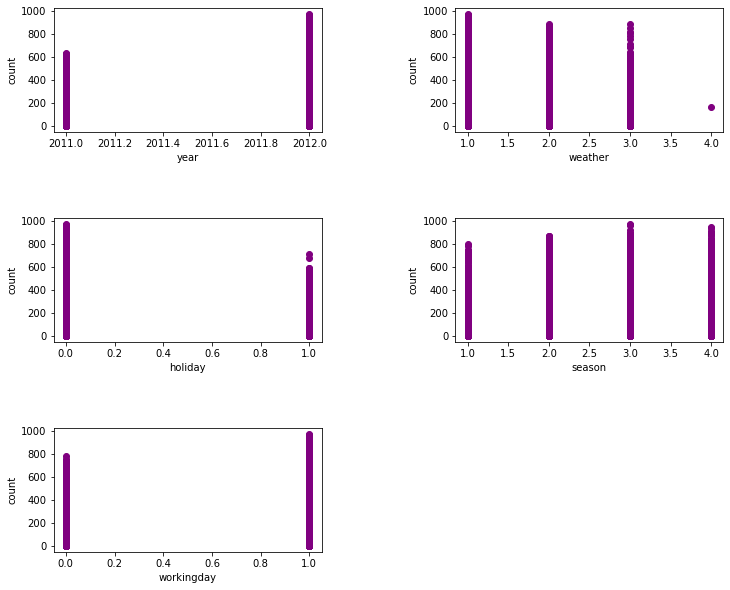

In [21]:
plot_count(data[data['count'].notnull()],disvar,'scatter') # 绘制离散变量散点图

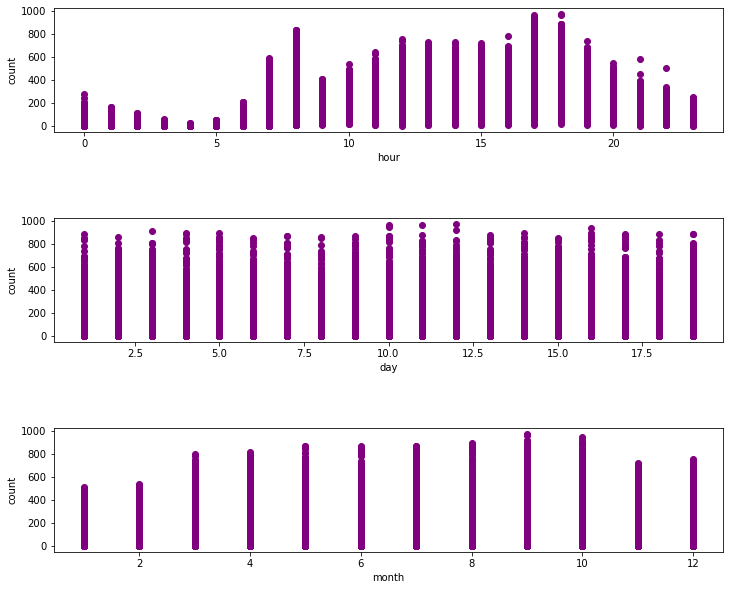

In [22]:
plot_count(data[data['count'].notnull()],multi_disvar,'scatter',col=1) # 绘制多值离散变量散点图

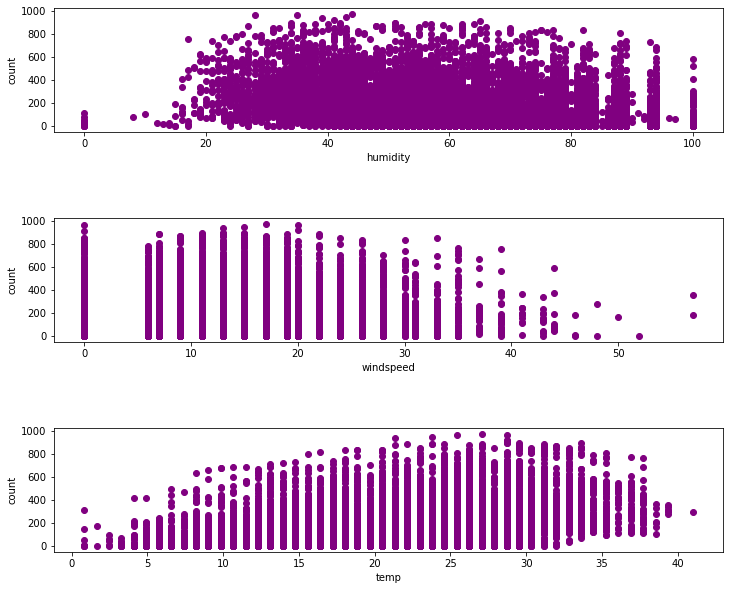

In [23]:
plot_count(data[data['count'].notnull()],convar,'scatter',col=1) # 绘制连续变量散点图

C:\Users\toyou\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\toyou\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'count_log')

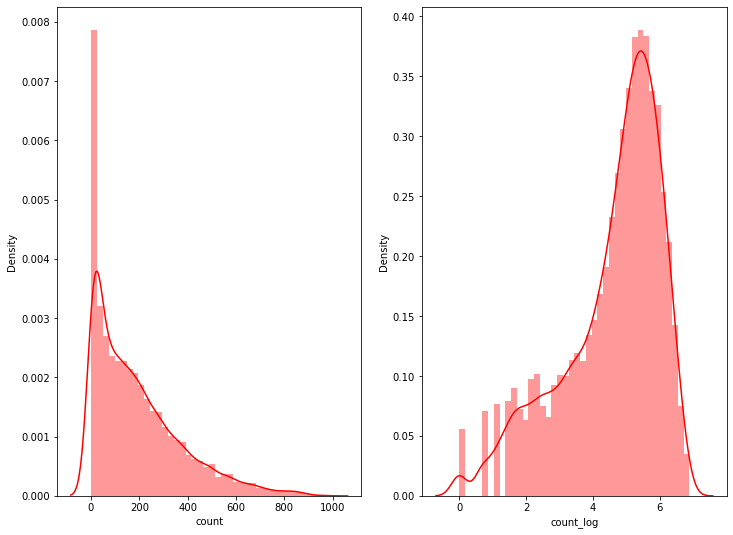

In [24]:
data['count_log'] = np.log(data['count'])
fig,axes = plt.subplots(1,2,figsize=(12,9))
sns.distplot(data['count'],bins=40,color='red',ax=axes[0])
plt.xlabel('count')
sns.distplot(data['count_log'],bins=40,color='red',ax=axes[1])
plt.xlabel('count_log')

<ipython-input-25-9cea5734abd7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ws0['windspeed_rf'] = rf_ws.predict(data_ws0[feature_ws].values)
C:\Users\toyou\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\toyou\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar

Text(0.5, 0, 'windspeed')

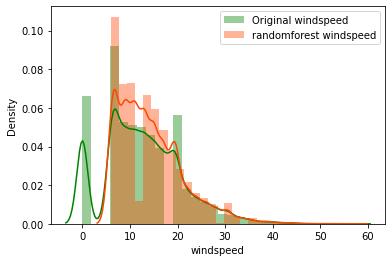

In [25]:
from sklearn.ensemble import RandomForestRegressor
feature_ws = ['weather','month','hour','temp','humidity','year']
data['windspeed_rf'] = data['windspeed']
data_ws0 = data[data.windspeed==0]
data_ws = data[data.windspeed!=0]
rf_ws = RandomForestRegressor(n_estimators=1000,criterion='mse',random_state=42,n_jobs=-1)
rf_ws.fit(data_ws[feature_ws].values,data_ws.windspeed.values)
data_ws0['windspeed_rf'] = rf_ws.predict(data_ws0[feature_ws].values)
data = pd.concat([data_ws0,data_ws],axis=0)
data.reset_index(drop=True,inplace=True)
plt.figure()
sns.distplot(data.windspeed,bins=30,color='green',label='Original windspeed')
sns.distplot(data.windspeed_rf,bins=30,color='orangered',label='randomforest windspeed')
plt.legend()
plt.xlabel('windspeed')

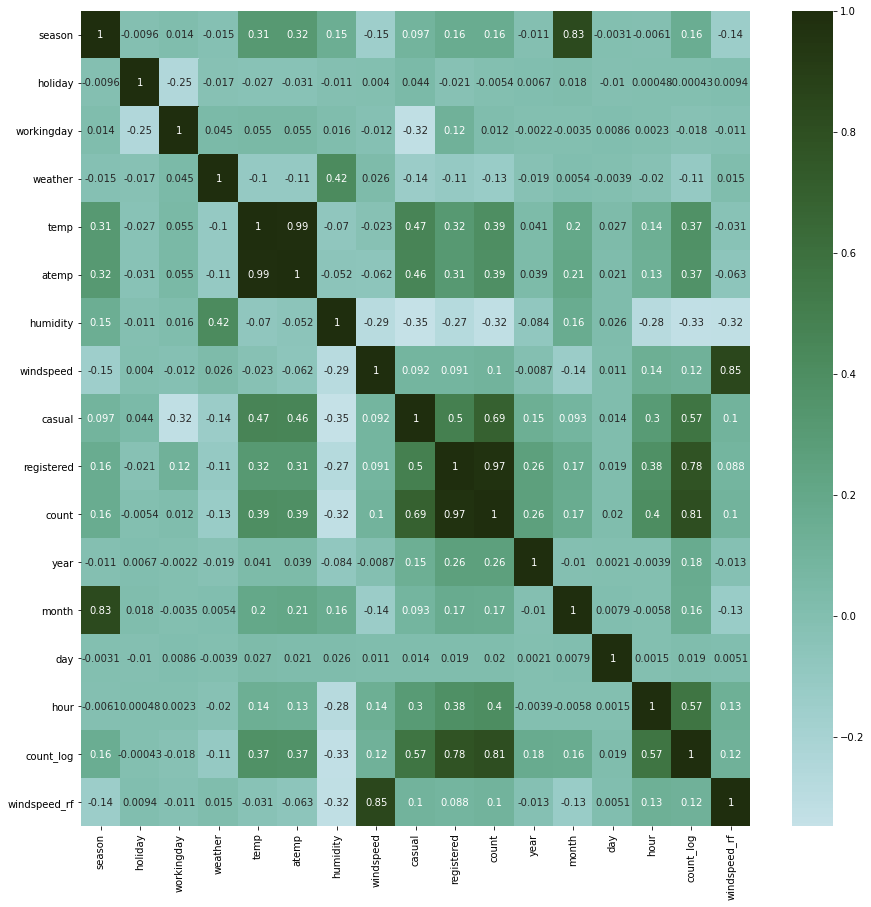

In [26]:
plt.figure(figsize=(15,15))
cmap=sns.cubehelix_palette(start=1.5,as_cmap=True)
sns.heatmap(data.corr(),annot=True,cmap=cmap)
plt.show()

In [78]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
data['temp_label'] = LabelEncoder().fit(data.temp_cat).transform(data.temp_cat)
data['humi_label'] = LabelEncoder().fit(data.humi_cat).transform(data.humi_cat)
data['windspeed_label'] = LabelEncoder().fit(data.windspeed_cat).transform(data.windspeed_cat)

data_year = pd.get_dummies(data=data.year,prefix='year')
data_month = pd.get_dummies(data=data.month,prefix='month')
data_season = pd.get_dummies(data=data.season,prefix='season')
data_holiday = pd.get_dummies(data=data.holiday,prefix='holiday')
data_workingday = pd.get_dummies(data=data.workingday,prefix='workingday')
data_weather = pd.get_dummies(data=data.weather,prefix='weather')
data = pd.concat([data,data_year,data_month,data_season,data_holiday,data_workingday,data_weather],axis=1)

In [79]:
def extract_feature(df,feature):
    X = df[feature].values
    Y = df['count_log']
    train_X,test_X,train_Y,test_Y = train_test_split(X,Y,test_size=0.2,random_state=42)
    return train_X,test_X,train_Y,test_Y

SyntaxError: invalid character in identifier (<ipython-input-79-16d9677624d6>, line 2)

In [ ]:
train_bike = data[data['count'].notnull()]
test_bike = data[data['count'].isnull()]

In [ ]:
feature =['holiday','workingday','weather','month','hour','temp_label','humi_label','windspeed_label','year_2011','year_2012']
train_X,test_X,train_Y,test_Y = extract_feature(train_bike,feature)
lr = LinearRegression()
lr.fit(train_X, train_Y)
pred_train_lr = lr.predict(train_X)
pred_test_lr = lr.predict(test_X)
print('RMSE of train data with lr is %.6f'%np.sqrt(mean_squared_error(train_Y,pred_train_lr)))
print('RMSE of test data with lr is %.6f'%np.sqrt(mean_squared_error(test_Y,pred_test_lr)))

In [ ]:
plt.scatter(pred_train_lr, train_Y, c = "blue", marker = "s", label = "Training data")
plt.scatter(pred_test_lr,test_Y, c = "lightgreen", marker = "s", label = "Testing data")
plt.title("LinearRegression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot( [0, 7], [0, 7],c = "red")
plt.show()

In [ ]:
rfr = RandomForestRegressor(n_estimators=1000,random_state=42,n_jobs=-1)
rfr.fit(train_X, train_Y)
pred_train_rfr = rfr.predict(train_X)
pred_test_rfr = rfr.predict(test_X)
print('RMSE of train data with rfr is %.6f'%np.sqrt(mean_squared_error(train_Y,pred_train_rfr)))
print('RMSE of test data with rfr is %.6f'%np.sqrt(mean_squared_error(test_Y,pred_test_rfr)))

In [ ]:
plt.scatter(pred_train_rfr, train_Y, c = "blue", marker = "s", label = "Training data")
plt.scatter(pred_test_rfr,test_Y, c = "lightgreen", marker = "s", label = "Testing data")
plt.title("RandomForestRegressor")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot( [0, 7], [0, 7],c = "red")
plt.show()